In [1]:
# Gym stuff
import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.evaluation import evaluate_policy

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch

# 1. Bring Data

In [2]:
df = pd.read_csv('stock_best_1y.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2024-05-20,169.000000,170.160004,168.380005,169.919998,164.925995,2726300
1,2024-05-21,169.940002,174.970001,169.940002,173.470001,168.371658,6459800
2,2024-05-22,173.389999,174.990005,172.759995,173.690002,168.585190,3294900
3,2024-05-23,175.389999,175.460007,170.440002,170.669998,165.653946,3341300
4,2024-05-24,171.479996,172.009995,170.210007,170.889999,165.867477,2587400


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [5]:
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-20,169.000000,170.160004,168.380005,169.919998,164.925995,2726300
2024-05-21,169.940002,174.970001,169.940002,173.470001,168.371658,6459800
2024-05-22,173.389999,174.990005,172.759995,173.690002,168.585190,3294900
2024-05-23,175.389999,175.460007,170.440002,170.669998,165.653946,3341300
2024-05-24,171.479996,172.009995,170.210007,170.889999,165.867477,2587400


In [6]:
env = gym.make('stocks-v0', df=df, frame_bound=(5,100), window_size=5)

In [7]:
env.unwrapped.signal_features

array([[ 1.6992000e+02,  0.0000000e+00],
       [ 1.7347000e+02,  3.5500031e+00],
       [ 1.7369000e+02,  2.2000122e-01],
       [ 1.7067000e+02, -3.0200043e+00],
       [ 1.7089000e+02,  2.2000122e-01],
       [ 1.6966000e+02, -1.2299957e+00],
       [ 1.6705000e+02, -2.6100006e+00],
       [ 1.6563000e+02, -1.4199982e+00],
       [ 1.6685001e+02,  1.2200012e+00],
       [ 1.6528000e+02, -1.5700073e+00],
       [ 1.6581000e+02,  5.2999878e-01],
       [ 1.6738000e+02,  1.5700073e+00],
       [ 1.6820000e+02,  8.1999207e-01],
       [ 1.7000999e+02,  1.8099976e+00],
       [ 1.7038000e+02,  3.7001038e-01],
       [ 1.6932001e+02, -1.0599976e+00],
       [ 1.6900000e+02, -3.2000732e-01],
       [ 1.6912000e+02,  1.1999512e-01],
       [ 1.6921001e+02,  9.0011597e-02],
       [ 1.6950000e+02,  2.8999329e-01],
       [ 1.7055000e+02,  1.0500031e+00],
       [ 1.7392000e+02,  3.3699951e+00],
       [ 1.7246001e+02, -1.4599915e+00],
       [ 1.7500999e+02,  2.5499878e+00],
       [ 1.72600

# 2. Build Environment

In [8]:
env.action_space

Discrete(2)

info {'total_reward': 23.83001708984375, 'total_profit': 0.8443878859470889, 'position': <Positions.Short: 0>}


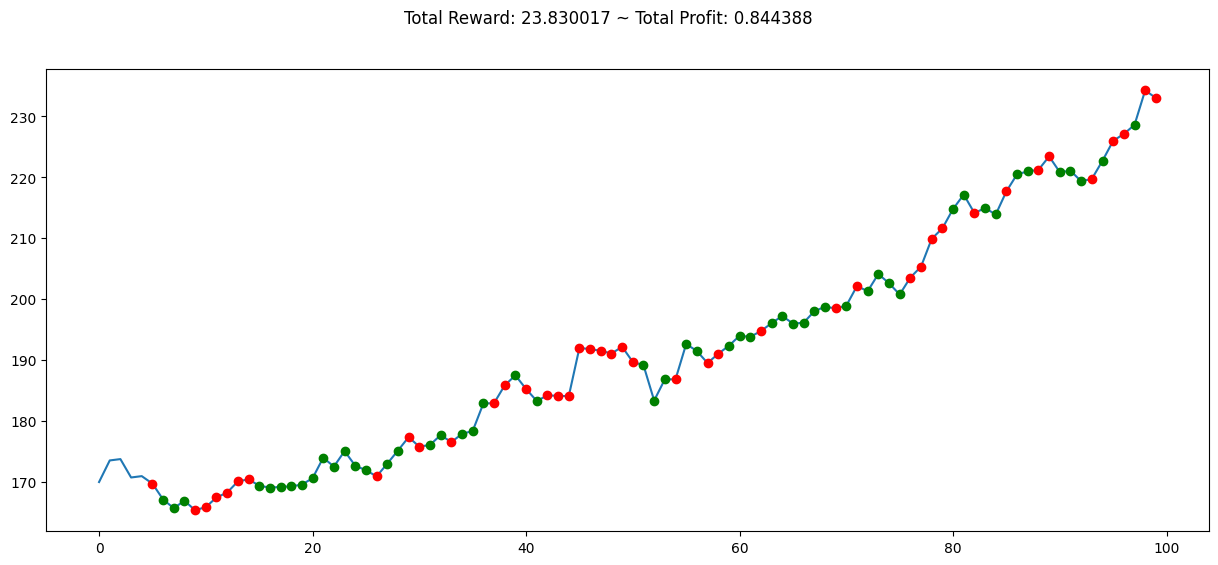

In [9]:
state = env.reset()
while True: 
    action = env.action_space.sample()
    n_state, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated: 
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.unwrapped.render_all()
plt.show()

# 3. Build Environment and Train

In [10]:
env_maker = lambda: gym.make('stocks-v0', df=df, frame_bound=(5,100), window_size=5)
env = DummyVecEnv([env_maker])

In [11]:
model = RecurrentPPO("MlpLstmPolicy", env, verbose=1)
model.learn(total_timesteps=100000)

Using cpu device
----------------------------
| time/              |     |
|    fps             | 757 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 128 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 87           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 256          |
| train/                  |              |
|    approx_kl            | 0.0022311634 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.692       |
|    explained_variance   | -0.000982    |
|    learning_rate        | 0.0003       |
|    loss                 | 2.65         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.0008      |
|    value_loss           | 5.64         |
------------------------------------------
------

In [12]:
model.save("recurrent_ppo_stocks_model.zip")

# 4. Evaluation

In [15]:
env = gym.make('stocks-v0', df=df, frame_bound=(90,110), window_size=5)
obs, info = env.reset()
while True: 
    action, _states = model.predict(obs)
    obs, rewards, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        print("info", info)
        break

info {'total_reward': 9.550018310546875, 'total_profit': 0.982009612493056, 'position': <Positions.Long: 1>}


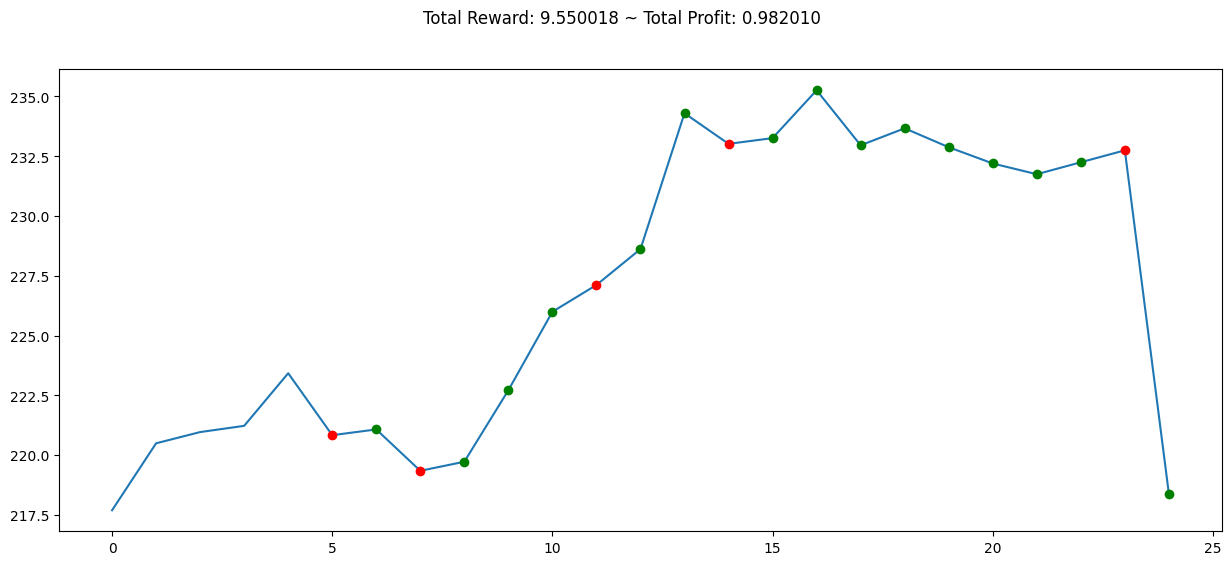

In [17]:
plt.figure(figsize=(15,6))
plt.cla()
env.unwrapped.render_all()
plt.show()